In [2]:
import torch
from torch import nn
from sklearn.preprocessing import Normalizer,StandardScaler
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

print(device)

cuda


In [4]:
dataframe = pd.read_excel('/content/dados_perturbacao36.xlsx')

In [5]:
dataframe.columns

Index(['Time', 'LiqFrac_H', 'LiqFrac_MET', 'LiqFrac_STY', 'LiqFrac_TOL',
       'LiqFrac_WAT', 'vapFrac_H', 'vapFrac_MET', 'vapFrac_STY', 'vapFrac_TOL',
       'vapFrac_WAT', 'P_bar', 'T_c', 'T_dec'],
      dtype='object')

In [6]:
data = dataframe[['Time', 'LiqFrac_H', 'LiqFrac_MET', 'LiqFrac_STY', 'LiqFrac_TOL',
       'LiqFrac_WAT', 'vapFrac_H', 'vapFrac_MET', 'vapFrac_STY', 'vapFrac_TOL',
       'vapFrac_WAT', 'P_bar', 'T_c']]
target = dataframe['T_dec']

In [7]:
normal = Normalizer()
data = normal.fit_transform(data)
#target = normal.fit_transform(target)
print(data.shape, target.shape)

print(data[14])
print(target[14])

(459, 13) (459,)
[6.97698153e-04 4.11033916e-06 4.81548773e-05 1.64729524e-03
 2.15036551e-04 1.75359454e-04 1.42387236e-03 3.55968588e-04
 1.42387236e-03 3.55968588e-04 1.42387236e-03 2.01834108e-02
 9.99791486e-01]
43.5869


In [8]:
# Cast na GPU
#data = torch.from_numpy(data).float()
#target = torch.from_numpy(target).float()
data = torch.FloatTensor(data).to(device) # GPU
target = torch.FloatTensor(target).to(device)

In [9]:
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return y_pred

In [10]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = data.shape[0], data.shape[1], 100, 1

# Create random Tensors to hold inputs and outputs
x = data
y = target



# Construct our model by instantiating the class defined above
model = TwoLayerNet(D_in, H, D_out).to(device)

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters of the two
# nn.Linear modules which are members of the model.

criterion = torch.nn.MSELoss().to(device)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.00001)

#criterion = torch.nn.L1Loss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5,weight_decay=5e-5)

lista_losses = []


for t in range(230000):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    #-------------r2_score-----------
    y_pred2 = y_pred.cpu().detach().numpy()
    y_true2 = target.cpu()
    y_true2 = y_true2.numpy()
    r2 = r2_score(y_true2,y_pred2)

    # Compute and print loss
    loss = criterion(y_pred.squeeze(), y)
    lista_losses.append(loss.item())
    


    if t % 10000 == 99:
        print(t, np.sqrt(loss.item()),np.mean(loss.item()))
        if r2 < 1 and r2 >= 0 :
          print('{} passadas , r2 = {}, Score MSE: {}'.format(t,r2, np.sqrt(loss.item())))
          if r2 > 0.98 and r2 < 1:
            break
        
    
        
        #if r2_score(y_true2,y_pred2) 


    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


#print(y_pred)

99 43.312247755849185 1875.9508056640625
10099 7.743112764779158 59.95579528808594
20099 0.5844421888678788 0.34157267212867737
20099 passadas , r2 = 0.23054360997085022, Score MSE: 0.5844421888678788
30099 0.5231154290785592 0.27364975214004517
30099 passadas , r2 = 0.38355264914414466, Score MSE: 0.5231154290785592
40099 0.5027595602631738 0.2527671754360199
40099 passadas , r2 = 0.43059460263924965, Score MSE: 0.5027595602631738
50099 0.47489561075767506 0.2255258411169052
50099 passadas , r2 = 0.49196078221663253, Score MSE: 0.47489561075767506
60099 0.4391576663831654 0.1928594559431076
60099 passadas , r2 = 0.5655479144359278, Score MSE: 0.4391576663831654
70099 0.3957163508201735 0.15659143030643463
70099 passadas , r2 = 0.6472484856731032, Score MSE: 0.3957163508201735
80099 0.3448796891263192 0.11894199997186661
80099 passadas , r2 = 0.73206085372587, Score MSE: 0.3448796891263192
90099 0.2871185872163529 0.08243708312511444
90099 passadas , r2 = 0.814295024423707, Score MSE: 

In [11]:
#pred = y_pred.cpu()
#y_true = target.cpu()
#y_true = y_true.numpy()
#pred = pred.detach().numpy()
vamover = y_true2 - y_pred2
print(vamover.max(), vamover.min())
#print(r2_score(y_true,pred))
#print(np.sqrt(mean_squared_error(y_true,pred)))
print(vamover)

2.2159424 -2.4244385
[[ 0.22239685  0.2152977   0.20729828 ...  1.1511993   1.1579971
   1.1647987 ]
 [ 0.2276535   0.22055435  0.21255493 ...  1.156456    1.1632538
   1.1700554 ]
 [ 0.2328949   0.22579575  0.21779633 ...  1.1616974   1.1684952
   1.1752968 ]
 ...
 [-0.97821045 -0.9853096  -0.993309   ... -0.04940796 -0.04261017
  -0.03580856]
 [-0.987175   -0.99427414 -1.0022736  ... -0.0583725  -0.05157471
  -0.0447731 ]
 [-0.9961395  -1.0032387  -1.0112381  ... -0.06733704 -0.06053925
  -0.05373764]]


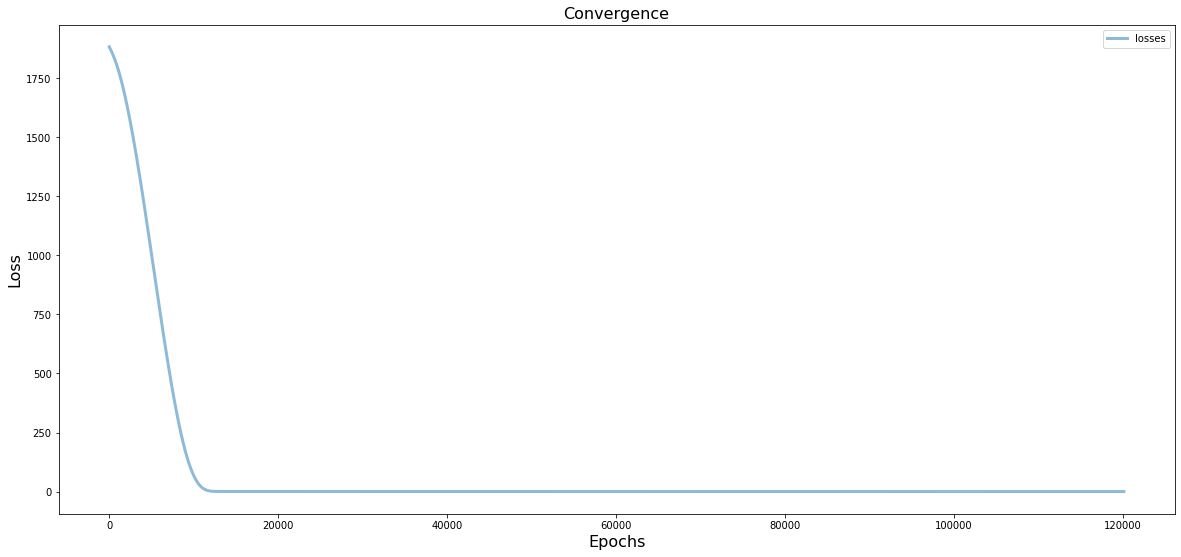

In [12]:
plt.figure(figsize=(20, 9))
#plt.plot(train_losses, label='Train')
plt.plot(lista_losses, label='losses', linewidth=3, alpha=0.5)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Convergence', fontsize=16)
plt.legend()
plt.show()